In [ ]:
import os
import pandas as pd
import glob
from PIL import Image, ImageOps
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from skimage.transform import resize
import random
import json
import cv2

# Get Data

Load 4 different folders of generated images of shapes and 4 corresponding csv files with the labels of the images, representing the fraction in each image

In [ ]:
!gdown --id 1-01XgZ2rFVrGtXYt2eIIIUL0CaO7zA9e ## shapes0.zip
!gdown --id 1a4AS1nQa_0v0PHrAxcHgb-i8XAfZ1zIr ## shapes1.zip
!gdown --id 1-sn1gg0NCpNEKxwjA1_rxNBYddltJNv5 ## shapes2.zip
!gdown --id 1xXFd1SkLDvEaYKdcw4qi2-kIfMFmIe1- ## shapes3.zip

!gdown --id 1-35wCawIg3sWJQ95D0U0TYzFH29qDyBE ## shapes_labels0.csv
!gdown --id 1jCBD5rqBNzlLovIlhckGUeXe2DR4tCEP ## shapes_labels1.csv
!gdown --id 1pPrhb_9APf0OHAtbJXjeKVvx_e73nzdo ## shapes_labels2.csv
!gdown --id 109yw0BhBnfnk2nroKRRMaD6XdQCQh7Vb ## shapes_labels3.csv

!unzip shapes0.zip
!unzip shapes1.zip
!unzip shapes2.zip
!unzip shapes3.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/shapes3/shape_1894.png  
  inflating: content/shapes3/shape_6100.png  
  inflating: content/shapes3/shape_9564.png  
  inflating: content/shapes3/shape_4056.png  
  inflating: content/shapes3/shape_6451.png  
  inflating: content/shapes3/shape_1088.png  
  inflating: content/shapes3/shape_6558.png  
  inflating: content/shapes3/shape_629.png  
  inflating: content/shapes3/shape_2257.png  
  inflating: content/shapes3/shape_1764.png  
  inflating: content/shapes3/shape_720.png  
  inflating: content/shapes3/shape_5550.png  
  inflating: content/shapes3/shape_7471.png  
  inflating: content/shapes3/shape_6246.png  
  inflating: content/shapes3/shape_692.png  
  inflating: content/shapes3/shape_9094.png  
  inflating: content/shapes3/shape_6056.png  
  inflating: content/shapes3/shape_1841.png  
  inflating: content/shapes3/shape_398.png  
  inflating: content/shapes3/shape_1560.png  
  inflating: content/shapes3/shap

In [ ]:
# %%script echo skipping
df = pd.read_csv('/content/shapes_labels0.csv', header=None)
df1 = pd.read_csv('/content/shapes_labels1.csv', header=None)
df2 = pd.read_csv('/content/shapes_labels2.csv', header=None)
df3 = pd.read_csv('/content/shapes_labels3.csv', header=None)

In [ ]:
file_path = '/content/drive/MyDrive/fraction_classifier'

Concatenate 4 generated data sets due to RAM limitations in generating

In [ ]:
%%script echo skipping
images = []
fractions = []

for current_df in [df, df1, df2, df3]:
  for i in range(len(current_df)):
    img = Image.open('/content' + current_df.iloc[i, 1])
    img = img.resize((224, 224))
    img = ImageOps.grayscale(img)
    images.append(np.array(img))
    fractions.append(current_df.iloc[i, 0])

skipping


In [ ]:
%%script echo skipping
os.makedirs(file_path, exist_ok=True)

np.save(os.path.join(file_path, 'shapes.npy'), images)
np.save(os.path.join(file_path, 'label_arrays.npy'), fractions)


skipping


In [ ]:
images = np.load(os.path.join(file_path, 'shapes.npy'))
fractions = np.load(os.path.join(file_path, 'label_arrays.npy'))

Convert the labels into integers by encoding them into a dictionary, where each fraction is represented by its index

In [ ]:
unique_fractions = set(fractions)

labels = {}
for i, frac in enumerate(unique_fractions):
    labels[frac] = i

Save the labels to load them in the same order in future runs

In [ ]:
# %%script echo skipping
# Set the path to your file in Google Drive
file_path = '/content/drive/MyDrive/fraction_classifier/labels_dict.json'

# Write the dictionary to the file in JSON format
with open(file_path, 'w') as f:
    json.dump(labels, f)

In [ ]:
# %%script echo skipping
integer_labels = [labels[frac] for frac in fractions]

Split the data into train and test

In [ ]:
# %%script echo skipping
X_train, X_test, y_train, y_test = train_test_split(images, integer_labels, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train = X_train.reshape(-1, 224, 224, 1)
X_test = X_test.reshape(-1, 224, 224, 1)
print(X_train.shape)

(40000, 224, 224, 1)


['2/4']


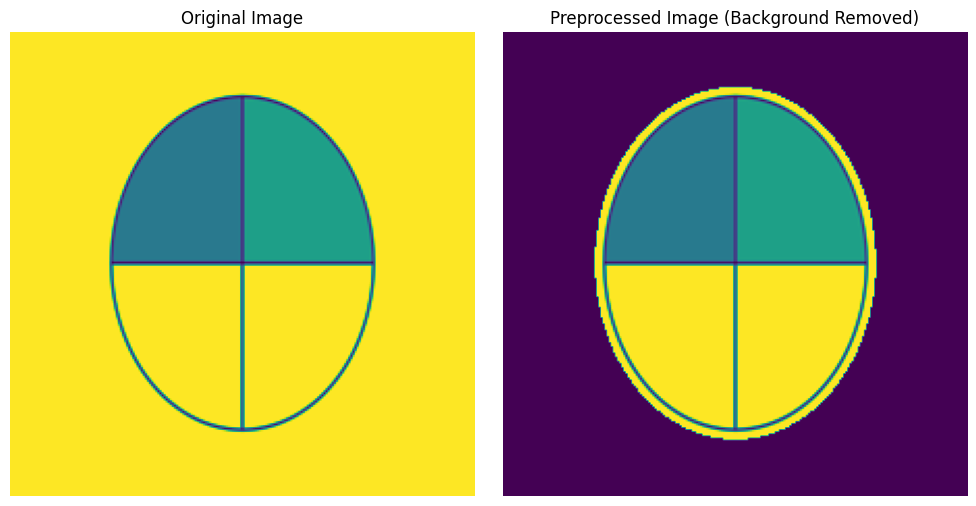

In [ ]:
def preprocess_image(img):
    # Convert the image to grayscale
    img_copy = img.copy()

    # Applying Gaussian blur to remove noise
    blur = cv2.GaussianBlur(img_copy, (11, 11), 0)

    # Setting threshold of gray image
    _, threshold = cv2.threshold(blur, 250, 255, cv2.THRESH_BINARY_INV)

    # Using findContours() function with RETR_EXTERNAL and CHAIN_APPROX_SIMPLE flags
    contours, _ = cv2.findContours(
        threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask to store the foreground (shape) pixels
    mask = np.zeros_like(img_copy)

    # Iterate through the contours and draw the shapes on the mask
    for contour in contours:
        # Approximate the contour to get the shape type
        perimeter = cv2.arcLength(contour, True)
        epsilon = 0.01 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Get the number of sides of the shape
        sides = len(approx)

        if sides == 3:
            # Fill the triangle contour on the mask
            cv2.drawContours(mask, [contour], 0, 255, -1)
        elif sides >= 4:
            # Fill the rectangle contour on the mask
            cv2.drawContours(mask, [contour], 0, 255, -1)
        else:
            # Fill the circle contour on the mask
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(mask, center, radius, 255, -1)

    # Apply the mask to the original image to extract the foreground (shape) pixels
    result = cv2.bitwise_and(img_copy, img_copy, mask=mask)

    # Add an additional dimension to the image array
    result = np.expand_dims(result, axis=-1)

    return result


number = 300  # Index of the image to preprocess
print([value for value in labels if labels[value] == y_train[number]])
image = np.squeeze(X_train[number])

# Preprocess the image
processed_image = preprocess_image(image)

# Display the original and preprocessed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(processed_image)
axes[1].set_title('Preprocessed Image (Background Removed)')
axes[1].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
for i in range(len(X_train)):
  X_train[i] = preprocess_image(X_train[i])

In [ ]:
for i in range(len(X_test)):
  X_test[i]= preprocess_image(X_test[i])

Streaming output truncated to the last 5000 lines.
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

In [ ]:
# %%script echo skipping
y_concat = np.concatenate((y_train, y_test))
num_unique_labels = len(np.unique(y_concat))

In [ ]:
# %%script echo skipping
print(X_train.shape)
print(y_train.shape)

(40000, 224, 224, 1)
(40000,)


# Build the model

In [ ]:
# %%script echo skipping
# create the model
model = Sequential()

# add convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_unique_labels, activation='softmax'))

In [ ]:
# %%script echo skipping
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

In [ ]:
# %%script echo skipping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
# Fit the model using the data generator
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    callbacks=[callback]
)

<ipython-input-26-a43e1b48a609>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/30
625/625 [==============================] - 141s 224ms/step - loss: 1.4223 - accuracy: 0.7210
Epoch 2/30
625/625 [==============================] - 142s 226ms/step - loss: 1.4097 - accuracy: 0.7237
Epoch 3/30
625/625 [==============================] - 143s 229ms/step - loss: 1.3976 - accuracy: 0.7290
Epoch 4/30
625/625 [==============================] - 141s 226ms/step - loss: 1.4045 - accuracy: 0.7272
Epoch 5/30
625/625 [==============================] - 144s 230ms/step - loss: 1.3958 - accuracy: 0.7309
Epoch 6/30
625/625 [==============================] - 145s 232ms/step - loss: 1.3859 - accuracy: 0.7312
Epoch 7/30
625/625 [==============================] - 144s 231ms/step - loss: 1.3963 - accuracy: 0.7296
Epoch 8/30
625/625 [==============================] - 144s 230ms/step - loss: 1.3983 - accuracy: 0.7290
Epoch 9/30
625/625 [==============================] - 141s 226ms/step - loss: 1.3756 - accuracy: 0.7352
Epoch 10/30
625/625 [==============================] - 141s 226m

# Save the model

In [ ]:
# %%script echo skipping
model_path = os.path.join('/content/drive/MyDrive/fraction_classifier', 'fraction_classifier_model' + '.h5')
model.save(model_path)

# Test Environment

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  test_image_path = fn

Load model

In [ ]:
!gdown --id 15o3hX_0-oVW1wuoMaQP3ufPFc-RfT360 ## model
!gdown --id 1byBHnFdc7MozCTc2mV0kIGqhX-hM5xDG ## labels

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15o3hX_0-oVW1wuoMaQP3ufPFc-RfT360
To: /content/fraction_classifier_model.h5
100% 119M/119M [00:01<00:00, 107MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1byBHnFdc7MozCTc2mV0kIGqhX-hM5xDG
To: /content/labels_dict.json
100% 596/596 [00:00<00:00, 3.57MB/s]


In [ ]:
model = load_model("/content/fraction_classifier_model.h5")

In [ ]:
# Load the JSON data from the file into a string
with open('/content/labels_dict.json', 'r') as f:
    json_str = f.read()

# Parse the JSON string into a Python dictionary
labels = json.loads(json_str)

Generate a random grid representing a fraction

In [ ]:
def generate_rectangle(filename):
  def generate_random_list(length):
    """Generates a list of random 1s and 0s of the given length."""
    return [random.randint(0, 1) for _ in range(length)]

  def create_grid(lst):
      """
      Takes a list of 0s and 1s and creates a grid with a random number of rows and columns,
      where each cell is colored white (0) or gray (1).
      """
      n = len(lst)
      configurations = [
          (n, 1),
          (1, n),
          (2, n//2),
          (n//2, 2),
          (3, n//3),
          (n//3, 3),
      ]

      flag = False
      while not flag:
        rows, cols = random.choice(configurations)
        if rows * cols == n:
          flag = True
      if not flag:
        raise ValueError("Input list length is not compatible with a rectangular grid.")
      grid = [[0 for _ in range(cols)] for _ in range(rows)]

      for i in range(rows):
          for j in range(cols):
              if lst[i*cols + j] == 1:
                  grid[i][j] = (0.5, 0.5, 0.5)  # Gray cell
              else:
                  grid[i][j] = (1, 1, 1)  # White cell

      return grid

  lst = generate_random_list(random.randint(1,9))
  grid = create_grid(lst)

  fig, ax = plt.subplots()
  ax.imshow(grid)

  ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_axis_off()

  for i in range(len(grid)):
      for j in range(len(grid[i])):
          rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', linewidth=2)
          ax.add_patch(rect)

  plt.savefig(filename, bbox_inches='tight', pad_inches=0.5)
  plt.close()

  return lst.count(1) / len(lst), f"{lst.count(1)}/{len(lst)}"

In [ ]:
def generate_pie(filename):
  a = 0
  b = 0

  while a+b == 0:
    a = random.randint(0,5)
    b = random.randint(0,5)

  fraction = f"{a}/{a+b}"

  fractions = []
  for i in range(a+b):
    fractions.append(1)

  colors = []
  for i in range(a):
    gray_shade = random.uniform(0.2, 0.8)
    colors.append((gray_shade, gray_shade, gray_shade))

  for i in range(b):
    colors.append('white')

  fig, ax = plt.subplots()
  wedges, _ = ax.pie(fractions, colors=colors, wedgeprops={'linewidth': 2, 'edgecolor': 'black'})
  ax.axis('equal')

  for wedge in wedges:
      wedge.set_linestyle('-')
      wedge.set_linewidth(2)
      wedge.set_edgecolor('black')

  plt.savefig(filename, bbox_inches='tight', pad_inches=0.5)
  plt.close()

  return a / (a + b), f"{a}/{a+b}"

In [ ]:
test_image_path = 'test_image.png'

In [ ]:
fraction_black_parts, label = generate_pie(test_image_path)

### Predicting the result of a single observation
This function reads the features as a Dataframe, encodes, scales and then it will return the prediction

In [ ]:
def single_predictor(image, model):
  my_prediction = model.predict(image)
  prediction = 0
  label = 0
  for i in range(my_prediction.shape[1]):
    if my_prediction[0][i] > prediction:
      prediction = my_prediction[0][i]
      label = i
  return (label)

### Test model

Read the image and reshape it for the model

In [ ]:
image = plt.imread(test_image_path)
resized_image = resize(image, (224, 224, 1))
expanded_image = resized_image[np.newaxis, ...] * 255.0

Predict the image label

1/1 [==============================] - 0s 22ms/step


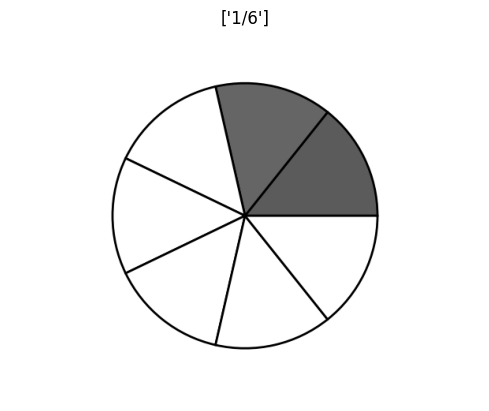

In [ ]:
predicted_label = single_predictor(expanded_image, model)
plt.axis('off')
plt.title([value for value in labels if labels[value] == predicted_label])
plt.imshow(image);